## Initialization

In [ ]:
import os
import sys
import matplotlib.pyplot as plt
import re

print(f'Current working directory is: {os.getcwd()}')
sys.path.append("../function")   

from camera import *
from translation_stage import *  


out_dir = "../../data/test/"
if not os.path.exists(out_dir):
   os.makedirs(out_dir)
   print("directory is created!")

# raster scanning, better to use odd numbers to center the scanning
Nx, Ny = 1, 1
scanning_step = 300e-6

Num = Nx*Ny


def show_camera_image(img_frame):
   plt.rcParams.update({'font.size': 14})
   fig, ax = plt.subplots(1, 2, sharey=False, figsize=(15, 3))
   h = ax[0].imshow(img_frame, cmap='gray')
   ax[0].axison = False
   ax[0].set_title('camera image')
   divider = make_axes_locatable(ax[0])
   cax = divider.append_axes("left", size="3%", pad=0.05)
   plt.colorbar(h, cax=cax, label='pixel value', location='left')

   img_flatten = img_frame.flatten()
   ax[1].hist(img_flatten, bins=256, weights=np.ones_like(img_flatten) / len(img_flatten), edgecolor='none')
   ax[1].set_ylabel('pixel count')
   ax[1].xlim = (0, 65535)
   ax[1].set_title('Histogram of the camera image')

   plt.show()


## OpenCV:


### [See3CAM_CU135M_H03R1](https://www.e-consystems.com/usb-cameras/ar1335-4k-monochrome-camera.asp)


4K Monochrome USB 3.1 Gen 1 Camera based on AR1335 CMOS Image sensor from ON Semiconductor®. 

Can stream uncompressed Ultra HD 4K@30fps and Full HD 1080p@60fps in both uncompressed and compressed MJPEG formats. 


Important notes:
- Python 3.11.4
- Opencv 4.6.0.66
- Copy `cv2.cp311-win_amd64.pyd' and  `opencv_videoio_ffmpeg460_64.dll' to  ..\python\Lib\site-packages\cv2\
- Copy `eCAMFwSw.dll' and  `opencv_world460.dll'  to  ..\python\
- `regsvr32 Y8GrabberFilter.dll'  in ..\opencv-master\Binary\Y8GrabberFilter\x64\ (e-CAM github folder)


In [3]:
import re

import cv2
import numpy as np
import sys
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from pygrabber.dshow_graph import FilterGraph


out_dir = "../../data/test/"

fourcc_names = ['CAP_PROP_POS_MSEC', 'CAP_PROP_POS_FRAMES', 'CAP_PROP_POS_AVI_RATIO', 'CAP_PROP_FRAME_WIDTH',
                'CAP_PROP_FRAME_HEIGHT', 'CAP_PROP_FPS', 'CAP_PROP_FOURCC', 'CAP_PROP_FRAME_COUNT', 'CAP_PROP_FORMAT',
                'CAP_PROP_MODE', 'CAP_PROP_BRIGHTNESS', 'CAP_PROP_CONTRAST', 'CAP_PROP_SATURATION', 'CAP_PROP_HUE',
                'CAP_PROP_GAIN', 'CAP_PROP_EXPOSURE', 'CAP_PROP_CONVERT_RGB', 'CAP_PROP_WHITE_BALANCE_BLUE_U',
                'CAP_PROP_RECTIFICATION', 'CAP_PROP_MONOCHROME', 'CAP_PROP_SHARPNESS', 'CAP_PROP_AUTO_EXPOSURE',
                'CAP_PROP_GAMMA', 'CAP_PROP_TEMPERATURE', 'CAP_PROP_TRIGGER', 'CAP_PROP_TRIGGER_DELAY',
                'CAP_PROP_WHITE_BALANCE_RED_V', 'CAP_PROP_ZOOM', 'CAP_PROP_FOCUS', 'CAP_PROP_GUID',
                'CAP_PROP_ISO_SPEED', 'CAP_PROP_BACKLIGHT', 'CAP_PROP_PAN', 'CAP_PROP_TILT', 'CAP_PROP_ROLL',
                'CAP_PROP_IRIS', 'CAP_PROP_SETTINGS', 'CAP_PROP_BUFFERSIZE', 'CAP_PROP_AUTOFOCUS']

def decode_fourcc(v):
    v = int(v)
    return "".join([chr((v >> 8 * i) & 0xFF) for i in range(4)])

devices_cv = FilterGraph().get_input_devices()
available_cameras = {}
for device_index in range(len(devices_cv)):
    available_cameras[device_index] = devices_cv[device_index]
print(f'Available camera: {available_cameras}\n')


cam = cv2.VideoCapture(0)
# cam = cv2.VideoCapture(0, cv2.CAP_MSMF) 
# cam = cv2.VideoCapture(0, cv2.CAP_V4L2) 
# cam = cv2.VideoCapture(0, cv2.CAP_FFMPEG)
# cam = cv2.VideoCapture(0, cv2.CAP_DSHOW)

if not (cam.isOpened()):
    print("Could not open camera.")
    sys.exit()
else:
    print("Backend Name:", cam.getBackendName())
    str = 'Old Camera settings: '
    for i in range(len(fourcc_names)):
        str = f'{str}{fourcc_names[i]}:{cam.get(i)}; '
    print(f'{str}')


cam.set(cv2.CAP_PROP_FRAME_WIDTH, 4200)
cam.set(cv2.CAP_PROP_FRAME_HEIGHT, 3120)
width, height = cam.get(cv2.CAP_PROP_FRAME_WIDTH), cam.get(cv2.CAP_PROP_FRAME_HEIGHT)
width, height = int(width), int(height)

cam.set(cv2.CAP_PROP_FOURCC, cv2.VideoWriter_fourcc('G','R','E','Y'))
# fmt = cam.set(cv2.CAP_PROP_FOURCC, cv2.VideoWriter_fourcc('Y','8',' ',' '))
# fmt = cam.set(cv2.CAP_PROP_FOURCC, cv2.VideoWriter_fourcc('Y', '1', '6', ' '))


cam.set(cv2.CAP_PROP_CONVERT_RGB, 0)
# cam.set(cv2.cvtColor(cv2.COLOR_YUV2GRAY_Y422))

# Fetch undecoded RAW video streams
cam.set(cv2.CAP_PROP_FORMAT, -1)  # value -1 to fetch undecoded RAW video streams (as Mat 8UC1)
# cam.set(cv2.CAP_PROP_FORMAT, cv2.CV_8UC1)

cam.set(cv2.CAP_PROP_AUTO_EXPOSURE, 1)  # 3: auto; 1: manual
# cam.set(cv2.CAP_PROP_SETTINGS, 1)

cam.set(cv2.CAP_PROP_FPS, 20)
cam.set(cv2.CAP_PROP_EXPOSURE, -8)
cam.set(cv2.CAP_PROP_GAIN, 0)
cam.set(cv2.CAP_PROP_GAMMA, 1)


# Check whether camera settings are applied
str = 'New camera settings: '
for i in range(len(fourcc_names)):
    str = f'{str}{fourcc_names[i]}:{cam.get(i)}; '
print(str)


success, frame = cam.read()
print(success)
if success:
    print(f'frame.shape = {frame.shape}, frame.dtype = {frame.dtype}')

    frame = frame.astype(np.uint16)*255

    show_camera_image(frame)

    cam_name = re.sub(r'\s+', '_', available_cameras[0])

    cv2.imwrite( f'{out_dir}{cam_name}_test_image.tiff', frame, [cv2.IMWRITE_TIFF_COMPRESSION, 1])

else:
    print('failed to grab frame')


cam.release()
cv2.destroyAllWindows()



Available camera: {0: 'See3CAM_CU135M_H03R1', 1: 'Basler GenICam Source', 2: 'Basler GenICam Source 2', 3: 'Basler GenICam Source 3', 4: 'Basler GenICam Source 4'}

Backend Name: MSMF
Old Camera settings: CAP_PROP_POS_MSEC:0.0; CAP_PROP_POS_FRAMES:0.0; CAP_PROP_POS_AVI_RATIO:-1.0; CAP_PROP_FRAME_WIDTH:1280.0; CAP_PROP_FRAME_HEIGHT:720.0; CAP_PROP_FPS:1.0; CAP_PROP_FOURCC:22.0; CAP_PROP_FRAME_COUNT:-1.0; CAP_PROP_FORMAT:-1.0; CAP_PROP_MODE:1.0; CAP_PROP_BRIGHTNESS:-1.0; CAP_PROP_CONTRAST:-1.0; CAP_PROP_SATURATION:-1.0; CAP_PROP_HUE:-1.0; CAP_PROP_GAIN:1.0; CAP_PROP_EXPOSURE:-6.0; CAP_PROP_CONVERT_RGB:1.0; CAP_PROP_WHITE_BALANCE_BLUE_U:1.0; CAP_PROP_RECTIFICATION:1.0; CAP_PROP_MONOCHROME:-1.0; CAP_PROP_SHARPNESS:-1.0; CAP_PROP_AUTO_EXPOSURE:0.0; CAP_PROP_GAMMA:-1.0; CAP_PROP_TEMPERATURE:-1.0; CAP_PROP_TRIGGER:1.0; CAP_PROP_TRIGGER_DELAY:1.0; CAP_PROP_WHITE_BALANCE_RED_V:1.0; CAP_PROP_ZOOM:-1.0; CAP_PROP_FOCUS:-1.0; CAP_PROP_GUID:1.0; CAP_PROP_ISO_SPEED:1.0; CAP_PROP_BACKLIGHT:-1.0; CAP_P

### HD USB Camera

IMX179  CMOS
Resolution: 3280(H) x 2464(V)
Pixel Size: 1.4 µm x 1.4 µm

In [ ]:
fourcc_names = ['CAP_PROP_POS_MSEC', 'CAP_PROP_POS_FRAMES', 'CAP_PROP_POS_AVI_RATIO', 'CAP_PROP_FRAME_WIDTH',
                'CAP_PROP_FRAME_HEIGHT', 'CAP_PROP_FPS', 'CAP_PROP_FOURCC', 'CAP_PROP_FRAME_COUNT', 'CAP_PROP_FORMAT',
                'CAP_PROP_MODE', 'CAP_PROP_BRIGHTNESS', 'CAP_PROP_CONTRAST', 'CAP_PROP_SATURATION', 'CAP_PROP_HUE',
                'CAP_PROP_GAIN', 'CAP_PROP_EXPOSURE', 'CAP_PROP_CONVERT_RGB', 'CAP_PROP_WHITE_BALANCE_BLUE_U',
                'CAP_PROP_RECTIFICATION', 'CAP_PROP_MONOCHROME', 'CAP_PROP_SHARPNESS', 'CAP_PROP_AUTO_EXPOSURE',
                'CAP_PROP_GAMMA', 'CAP_PROP_TEMPERATURE', 'CAP_PROP_TRIGGER', 'CAP_PROP_TRIGGER_DELAY',
                'CAP_PROP_WHITE_BALANCE_RED_V', 'CAP_PROP_ZOOM', 'CAP_PROP_FOCUS', 'CAP_PROP_GUID',
                'CAP_PROP_ISO_SPEED', 'CAP_PROP_BACKLIGHT', 'CAP_PROP_PAN', 'CAP_PROP_TILT', 'CAP_PROP_ROLL',
                'CAP_PROP_IRIS', 'CAP_PROP_SETTINGS', 'CAP_PROP_BUFFERSIZE', 'CAP_PROP_AUTOFOCUS']


def decode_fourcc(v):
    v = int(v)
    return "".join([chr((v >> 8 * i) & 0xFF) for i in range(4)])

devices_cv = FilterGraph().get_input_devices()
available_cameras = {}
for device_index in range(len(devices_cv)):
    available_cameras[device_index] = devices_cv[device_index]
print(f'Available camera: {available_cameras}\n')


cam = cv2.VideoCapture(0, cv2.CAP_DSHOW) 

if not (cam.isOpened()):
    print("Could not open camera.")
    sys.exit()
else:
    # print('fourcc:', decode_fourcc(cam.get(cv2.CAP_PROP_FOURCC)))
    print(f'Camera is open. Using device of {available_cameras[0]}')
    print("Backend Name:", cam.getBackendName())
    str = 'Old Camera settings: '
    for i in range(len(fourcc_names)):
        str = f'{str}{fourcc_names[i]}:{cam.get(i)}; '
    print(f'{str}')

cam.set(cv2.CAP_PROP_XI_OFFSET_X, 0)
cam.set(cv2.CAP_PROP_XI_OFFSET_Y, 0)
cam.set(cv2.CAP_PROP_FRAME_WIDTH, 3264)
cam.set(cv2.CAP_PROP_FRAME_HEIGHT, 2448)   

# cam.set(cv2.CAP_PROP_MODE, 3.0)
cam.set(cv2.CAP_PROP_AUTO_EXPOSURE, 1)  # 3: auto; 1: manual
# cam.set(cv2.CAP_PROP_SETTINGS, 1)

cam.set(cv2.CAP_PROP_FPS, 15)
cam.set(cv2.CAP_PROP_EXPOSURE, -8)
cam.set(cv2.CAP_PROP_GAIN, 8)
cam.set(cv2.CAP_PROP_GAMMA, 72)
cam.set(cv2.CAP_PROP_CONTRAST, 64)
cam.set(cv2.CAP_PROP_BRIGHTNESS, 0)
cam.set(cv2.CAP_PROP_SATURATION, 0)
cam.set(cv2.CAP_PROP_SHARPNESS, 0)
cam.set(cv2.CAP_PROP_HUE, 0)
cam.set(cv2.CAP_PROP_IOS_DEVICE_WHITEBALANCE, 4600)

# cam.OffsetX, cam.OffsetY = 0.0, 0.0
width, height = int(cam.get(cv2.CAP_PROP_FRAME_WIDTH)), int(cam.get(cv2.CAP_PROP_FRAME_HEIGHT))

# cam.set(cv2.CAP_PROP_FOURCC, cv2.VideoWriter.fourcc('Y', 'U', 'Y', 'V'))    # frame rate = 2
# cam.set(cv2.CAP_PROP_FOURCC, cv2.VideoWriter.fourcc('Y', '1', '6', ' '))
cam.set(cv2.CAP_PROP_FOURCC, cv2.VideoWriter.fourcc('M', 'J', 'P', 'G'))
cam.set(cv2.CAP_PROP_CONVERT_RGB, 0)

# Fetch undecoded RAW video streams
cam.set(cv2.CAP_PROP_FORMAT, -1)  # value -1 to fetch undecoded RAW video streams (as Mat 8UC1)

# Check whether camera settings are applied
str = 'New camera settings: '
for i in range(len(fourcc_names)):
    str = f'{str}{fourcc_names[i]}:{cam.get(i)}; '
print(str)


success, frame = cam.read()
print(success)
if success:
    print(f'frame.shape = {frame.shape}, frame.dtype = {frame.dtype}')

    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    frame = np.uint16(frame)*256

    show_camera_image(frame)

    cam_name = re.sub(r'\s+', '_', available_cameras[0])

    cv2.imwrite( f'{out_dir}{cam_name}_test_image.tiff', frame, [cv2.IMWRITE_TIFF_COMPRESSION, 1])

else:
    print('failed to grab frame')


cam.release()
cv2.destroyAllWindows()

### Sony imx179 8MP

# The Imaging Source

### [DFM 37UX226-ML](https://www.theimagingsource.com/en-us/product/board/37u/dfm37ux226ml/?adsdyn&gclid=Cj0KCQjw_5unBhCMARIsACZyzS0iRZb2lkuSpOrEfeROVDZfZ4oOCnEkGMHTRSXjVeKPhrQ3yPQ03_EaAlgUEALw_wcB)


Sony CMOS STARVIS IMX226 Sensor

Color 

Sensor Specification	Sony IMX226

Pixel Size	H: 1.85 µm, V: 1.85 µm

Lens Mount	M12x0.5

In [1]:
import ctypes
import tisgrabber as tis
import numpy as np
import imutils
import cv2

ic = ctypes.cdll.LoadLibrary("./tisgrabber_x64.dll")
tis.declareFunctions(ic)

ic.IC_InitLibrary(0)
devicecount = ic.IC_GetDeviceCount()
grabbers = []
for i in range(0, devicecount):
    print("Device {}".format(tis.D(ic.IC_GetDevice(i))))
    uniquename = tis.D(ic.IC_GetUniqueNamefromList(i))
    print("Unique Name : {}".format(uniquename))
    

hGrabber = ic.IC_CreateGrabber()

ic.IC_OpenVideoCaptureDevice(hGrabber,"DFM 37UX226-ML".encode("utf-8"))
if ic.IC_IsDevValid(hGrabber): 
    ic.IC_SetVideoFormat(hGrabber, "RGB64 (4000x3000)".encode("utf-8"))       # automatic debayering of the raw image data
    # ic.IC_SetVideoFormat(hGrabber, "Y800 (4000x3000)".encode("utf-8"))      # contains the raw data which is reinterpreted as monochrome.
    ic.IC_SetFrameRate(hGrabber, ctypes.c_float(20.0))
    ic.IC_SetPropertyValue(hGrabber, tis.T("Partial scan"), tis.T("Y Offset"), 0)
    ic.IC_SetPropertyValue(hGrabber, tis.T("Partial scan"), tis.T("X Offset"), 0)
    
    # ic.IC_SetFormat(hGrabber,  ctypes.c_int(1))   #???

    ic.IC_SetPropertySwitch(hGrabber, tis.T("Exposure"), tis.T("Auto"), 0)
    ic.IC_SetPropertyAbsoluteValue(hGrabber, tis.T("Exposure"), tis.T("Value"), ctypes.c_float(1/600))

    # g = ctypes.c_float()
    # ic.IC_GetPropertyAbsoluteValue(hGrabber, tis.T("Gain"), tis.T("Value"), g)
    # print('Gain is ', g.value)

    ic.IC_SetPropertySwitch(hGrabber, tis.T("Gain"), tis.T("Auto"), 0)
    ic.IC_SetPropertyValue(hGrabber, tis.T("Gain"), tis.T("Value"),  ctypes.c_float(0))

    # g = ctypes.c_float()
    # ic.IC_GetPropertyAbsoluteValue(hGrabber, tis.T("Gamma"), tis.T("Value"), g)
    # print('Gamma is ', g.value)

    ic.IC_SetPropertySwitch(hGrabber, tis.T("Gamma"), tis.T("Auto"), 0)
    ic.IC_SetPropertyValue(hGrabber, tis.T("Gamma"), tis.T("Value"),  ctypes.c_float(2.0))
    
    ic.IC_StartLive(hGrabber, 1)
    if ic.IC_SnapImage(hGrabber, 2000) == tis.IC_SUCCESS:
        Width = ctypes.c_long()
        Height = ctypes.c_long()
        BitsPerPixel = ctypes.c_int()
        colorformat = ctypes.c_int()       

        # Query the values of image description
        ic.IC_GetImageDescription(hGrabber, Width, Height, BitsPerPixel, colorformat)

        print(f'width is  {Width.value}; BitsPerPixel is {BitsPerPixel.value}; colorformat is {colorformat.value}')

        # Calculate the buffer size
        bpp = int(BitsPerPixel.value / 8.0)
        buffer_size = Width.value * Height.value * BitsPerPixel.value

        print(f'BitsPerPixel is {BitsPerPixel.value}; bpp is {bpp}; buffer_size is {buffer_size}')

        # Get the image data
        imagePtr = ic.IC_GetImagePtr(hGrabber)
        # imagedata = ctypes.cast(imagePtr, ctypes.POINTER(ctypes.c_ubyte *buffer_size))
        imagedata = ctypes.cast(imagePtr, ctypes.POINTER(ctypes.c_uint16 *buffer_size))


        # Create the numpy array
        image = np.ndarray(buffer=imagedata.contents, dtype=np.uint8, shape=(Height.value, Width.value, bpp))        
        image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        image = np.uint16(image)*256
        image = imutils.rotate(cv2.flip(image, 1), angle=180)

        show_camera_image(image)

        cam_name = re.sub(r'\s+', '_', ic.IC_GetDevice(0).decode())        
        cv2.imwrite( f'{out_dir}{cam_name}_test_image.tiff', image, [cv2.IMWRITE_TIFF_COMPRESSION, 1])

        print("Image saved.")

    else:
        print("No frame received in 2 seconds.")

    ic.IC_StopLive(hGrabber)

else:
    ic.IC_MsgBox("No device opened".encode("utf-8"), "Simple Live Video".encode("utf-8"),)

ic.IC_ReleaseGrabber(hGrabber)


Device DFM 37UX226-ML
Unique Name : DFM 37UX226-ML 14220261
width is  4000; BitsPerPixel is 24; colorformat is 1
BitsPerPixel is 24; bpp is 3; buffer_size is 288000000


NameError: name 'show_camera_image' is not defined

: 

In [5]:
ic.IC_StopLive(hGrabber)

562774413

## Basler 

###  [Basler daA3840-45um](https://www.baslerweb.com/en/products/cameras/area-scan-cameras/dart/daa3840-45um-s-mount/) 


- Sensor with diffuser
- Sensor	IMX334 	CMOS
- Sensor Size	7.7 mm x 4.3 mm
- Resolution (HxV)	3840 px x 2160 px
- Resolution	8.3 MP
- Pixel Size (H x V)	2 µm x 2 µm
- Frame Rate	45 fps
- Mono/Color	Mono

In [ ]:
Basler.list_cameras()

tlf = pylon.TlFactory.GetInstance()
available_cameras = {}
devices_pylon = tlf.EnumerateDevices()
for device_index in range(len(devices_pylon)):
    available_cameras[device_index] = devices_pylon[device_index].GetFriendlyName()

print(f'Available camera: {available_cameras}')


In [ ]:
tlf = pylon.TlFactory.GetInstance()
devices = tlf.EnumerateDevices()

try:
    cam = pylon.InstantCamera(tlf.CreateDevice(devices[0]))
    cam.Open()
    print(f'Camera is open. Using device of {cam.GetDeviceInfo().GetModelName()}')

except:
    print("Camera is not open.")
    cam.StopGrabbing()
    cam.DeviceReset.Execute()
    cam.Close()


#########################  Camera setting #################################
basler_names = ["AcquisitionFrameRate", "Width", "Height", "PixelFormat", "ExposureTime", "Gain", "BslBrightness", "BslContrast"]

str = f'Default settings: Avaible pixelformat: {cam.PixelFormat.Symbolics}; \n'
for i in range(len(basler_names)):
    str = f'{str}{basler_names[i]}: {cam.GetNodeMap().GetNode(basler_names[i]).ToString()}; '
print(str)

cam.AcquisitionStop.Execute()        # cam stop
cam.TLParamsLocked = False           # grab unlock

cam.OffsetX, cam.OffsetY = 0, 0
cam.Width, cam.Height = cam.Width.Max, cam.Height.Max
width, height = cam.Width, cam.Height

cam.AcquisitionFrameRateEnable = True
cam.BslContrastMode = "Linear"
cam.MaxNumBuffer = 150

cam.AcquisitionFrameRate = 30
cam.BslBrightness = 0.1   
cam.BslContrast = 0.3        
cam.PixelFormat = "Mono12"     
cam.Gain = 1                   
cam.ExposureTime = 5000   
cam.StaticChunkNodeMapPoolSize = cam.MaxNumBuffer.GetValue()

cam.TLParamsLocked = True              # grab lock
cam.AcquisitionStart.Execute()         # cam start

str = 'New camera settings: \n'
for i in range(len(basler_names)):
    str = f'{str}{basler_names[i]}: {cam.GetNodeMap().GetNode(basler_names[i]).ToString()}; '
print(str)

############################## Test capture ##################################
cam.StartGrabbing()
result = cam.RetrieveResult(2000, pylon.TimeoutHandling_ThrowException)   # Wait for an image and retrieve it. A timeout of 2000 ms is used.
if result.GrabSucceeded():
    frame = result.Array
    show_camera_image(frame)

# Save captured images
img = pylon.PylonImage()
with cam.RetrieveResult(2000) as result:
    if result.GrabSucceeded():
        img.AttachGrabResultBuffer(result)        

        if platform.system() == 'Windows':
            img.Save(pylon.ImageFileFormat_Tiff, f'{out_dir}{cam.GetDeviceInfo().GetModelName()}_test_image.tiff')
            # img.Save(pylon.ImageFileFormat_Raw, filename)
        else:
            img.Save(pylon.ImageFileFormat_Png, f'{out_dir}{cam.GetDeviceInfo().GetModelName()}_test_image.tiff')

result.Release()


cam.StopGrabbing()
cam.DeviceReset.Execute()
cam.Close()

### [Basler daA1920-160um](https://www.baslerweb.com/en/products/cameras/area-scan-cameras/dart/daa1920-160um-cs-mount/)

- IMX392 CMOS sensor.
- Resolution (HxV)	1920 px x 1200 px
- Pixel Size (HxV)	3.45 µm x 3.45 µm
- Mono

In [ ]:
# tlf = pylon.TlFactory.GetInstance()
# devices = tlf.EnumerateDevices()

# try:
#     cam = pylon.InstantCamera(tlf.CreateDevice(devices[0]))
#     cam.Open()
#     print("Camera is open.")
# except:
#     print("Camera is not open.")
#     cam.StopGrabbing()
#     cam.DeviceReset.Execute()
#     cam.Close()


# #########################  Camera setting #################################
# cam.AcquisitionStop.Execute()        # cam stop
# cam.TLParamsLocked = False           # grab unlock

# cam.OffsetX, cam.OffsetY = 0, 0
# cam.Width, cam.Height = cam.Width.Max, cam.Height.Max
# width, height = cam.Width, cam.Height

# cam.AcquisitionFrameRateEnable = True
# cam.BslContrastMode = "Linear"
# cam.MaxNumBuffer = 150

# # print("\nCurrent settings:")
# # for feature in cam.GetNodeMap():
# #     print(f"{feature.ToString()}")


# cam.AcquisitionFrameRate = 30
# cam.BslBrightness = 0.1    # 0.1
# cam.BslContrast = 0.3        # 0.3
# cam.PixelFormat = "Mono12"     # "Mono12"
# cam.Gain = 1                   # 1
# cam.ExposureTime = 4000   # 4000ms
# cam.StaticChunkNodeMapPoolSize = cam.MaxNumBuffer.GetValue()

# cam.TLParamsLocked = True              # grab lock
# cam.AcquisitionStart.Execute()         # cam start

# # basler_names = ['ExposureTimeAbs']

# # print('New camera settings:')
# # str = ''
# # for i in range(len(basler_names)):
# #     str = f'{str} {basler_names[i]}:{cam.GetParameter(pylon.Camara.basler_names[i])};'
# # print(str)

# ############################## Test setting ##################################
# cam.StartGrabbing()
# result = cam.RetrieveResult(2000, pylon.TimeoutHandling_ThrowException)   # Wait for an image and retrieve it. A timeout of 2000 ms is used.
# if result.GrabSucceeded():
#     frame = result.Array
#     show_camera_image(frame)

# cam.StopGrabbing()
# cam.DeviceReset.Execute()
# cam.Close()

### Basler [daA3840-45uc](https://www.baslerweb.com/en/products/cameras/area-scan-cameras/dart/daa3840-45uc-s-mount/)

- IMX334 CMOS sensor
- Resolution (HxV)	3840 px x 2160 px
- Pixel Size (H x V)	2 µm x 2 µm
- Frame Rate	45 fps
- Mono/Color	Color


In [6]:
Basler.list_cameras()

tlf = pylon.TlFactory.GetInstance()
available_cameras = {}
devices_pylon = tlf.EnumerateDevices()
for device_index in range(len(devices_pylon)):
    available_cameras[device_index] = devices_pylon[device_index].GetFriendlyName()

print(f'Available camera: {available_cameras}')

Available camera: {0: 'Basler daA3840-45uc (40316613)'}


Camera is open. Using device of daA3840-45uc
Default settings: Avaible pixelformat: ('Mono8', 'Mono12', 'Mono12p', 'RGB8', 'BGR8', 'YCbCr422_8', 'BayerRG8', 'BayerRG12', 'BayerRG12p'); 
Width: 3840; Height: 2160; PixelFormat: BayerRG8; ExposureTime: 15000.0; Gain: 0.000; BslBrightness: 0.000; BslContrast: 0.000; 
New camera settings: 
Width: 3860; Height: 2178; PixelFormat: Mono12; ExposureTime: 5000.0; Gain: 1.000; BslBrightness: 0.102; BslContrast: 0.000; 


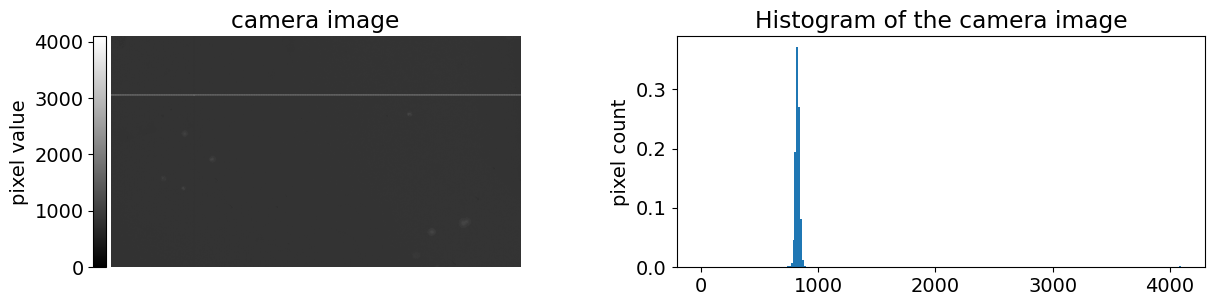

In [11]:

tlf = pylon.TlFactory.GetInstance()
devices = tlf.EnumerateDevices()

try:
    cam = pylon.InstantCamera(tlf.CreateDevice(devices[0]))
    cam.Open()
    print(f'Camera is open. Using device of {cam.GetDeviceInfo().GetModelName()}')

except:
    print("Camera is not open.")
    cam.StopGrabbing()
    cam.DeviceReset.Execute()
    cam.Close()


#########################  Camera setting #################################
basler_names = ["Width", "Height", "PixelFormat", "ExposureTime", "Gain", "BslBrightness", "BslContrast"]

str = f'Default settings: Avaible pixelformat: {cam.PixelFormat.Symbolics}; \n'
for i in range(len(basler_names)):
    str = f'{str}{basler_names[i]}: {cam.GetNodeMap().GetNode(basler_names[i]).ToString()}; '
print(str)


cam.AcquisitionStop.Execute()        # cam stop
cam.TLParamsLocked = False           # grab unlock

cam.OffsetX, cam.OffsetY = 0, 0
cam.Width, cam.Height = cam.Width.Max, cam.Height.Max
width,height = cam.Width, cam.Height

cam.AcquisitionFrameRateEnable = True
cam.BslContrastMode = "Linear"
cam.MaxNumBuffer = 150


cam.AcquisitionFrameRate = 30
# set color space mode to "off" for mask camera since it's not mono camera
cam.BslHue = 0
cam.BslSaturation = 0
cam.BslColorSpace = "Off"
cam.BslBrightness = 0.1    # 0.1
cam.BslContrast = 0        # 0.3
cam.PixelFormat = "Mono12"     # "Mono12"
cam.Gain = 1                   # 1
cam.Gamma = 1                   # 1
cam.ExposureTime = 5000   # 4000ms
cam.StaticChunkNodeMapPoolSize = cam.MaxNumBuffer.GetValue()

cam.TLParamsLocked = True              # grab lock
cam.AcquisitionStart.Execute()         # cam start

str = 'New camera settings: \n'
for i in range(len(basler_names)):
    str = f'{str}{basler_names[i]}: {cam.GetNodeMap().GetNode(basler_names[i]).ToString()}; '
print(str)

############################## Test setting ##################################
cam.StartGrabbing()
result = cam.RetrieveResult(2000, pylon.TimeoutHandling_ThrowException)   # Wait for an image and retrieve it. A timeout of 2000 ms is used.
if result.GrabSucceeded():
    frame = result.Array
    show_camera_image(frame)

# Save captured images
img = pylon.PylonImage()
with cam.RetrieveResult(2000) as result:
    if result.GrabSucceeded():
        img.AttachGrabResultBuffer(result)        

        if platform.system() == 'Windows':
            img.Save(pylon.ImageFileFormat_Tiff,  f'{out_dir}{cam.GetDeviceInfo().GetModelName()}_test_image.tiff')
            # img.Save(pylon.ImageFileFormat_Raw, filename)
        else:
            img.Save(pylon.ImageFileFormat_Png,  f'{out_dir}{cam.GetDeviceInfo().GetModelName()}_test_image.tiff')

result.Release()


cam.StopGrabbing()
cam.DeviceReset.Execute()
cam.Close()

# Test Camera class

Current working directory is: d:\OneDrive - SNU\work\research\0-UV-Lensless\code\pytorch\test
Available cameras: {0: 'DFM 37UX226-ML'}
Camera is open make settings...


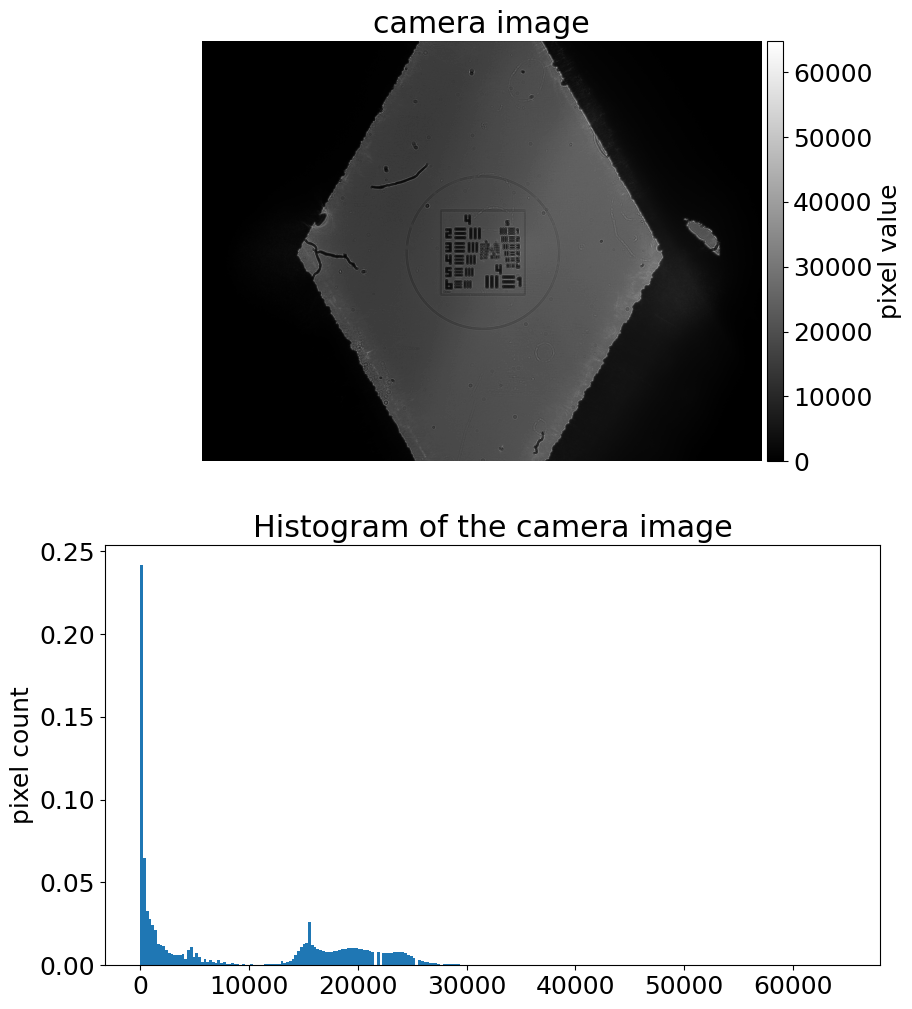

Camera is closed.


In [1]:
import os
import sys


print(f'Current working directory is: {os.getcwd()}')
sys.path.append("../function")
sys.path.append("../utils")


from camera import *

out_dir = "../../data/test/"
if not os.path.exists(out_dir):
   os.makedirs(out_dir)
   print("directory is created!")



c = Camera(camera_mode='DFM 37UX226-ML', gain=2.0, framerate=20, pixelformat="RGB32 (4000x3000)", exposuretime=0.05)
# c = Camera(camera_mode='Basler daA1920-160um', brightness=0.1, contrast=0.3, gain=1.0, framerate=30, pixelformat="Mono12", exposuretime=7000)
# c = Camera(camera_mode='DFM 37UX226-ML', brightness=0, contrast=0, gain=0, framerate=20, gamma=200, exposuretime=1/100)
# c = Camera(camera_mode='CU135M_H03R1', brightness=0.1, contrast=0.3, gain=1.0, framerate=30, pixelformat="Mono12", exposuretime=7000)

c.set_camera()

cam_name = re.sub(r'\s+', '_', c.camera_mode)
file_name = f'{out_dir}/{cam_name}.tiff'


c.capture(file_name)


c.close()